# 前情回顾
numpy/matplotlib/torch/cv/pillow/PLL等这些包的API没必要记

会一个其他都会了,可以看官方文档,英文要好

# 综述
这节正式接触计算机视觉:
- 传统计算机哪些算法
- 图像(像素图not矢量图)的本质是什么(三维矩阵)
- 对于图像的基础操作,切除拉伸等等
- 局部特征, 而不是看一个pixel像素点

本节内容:
- 卷积Convolution & Applications
- 关键点 Feature Points
- 针对关键点机器学习的算法


# 卷积

## 什么是卷积 
数学里的卷积是
$$
 \int_{-\infty  }^{\infty }f(\tau )g(x-\tau)d\tau=f(x)\ast g(x)
$$
或者
$$
y(n)=\sum_{i=-\infty}^{\infty }x(i)h(n-i)=x(n)*h(n)
$$


我们这里是图像里的卷积,数学里叫互相关
$$
f(k_{1},k{2})\cdot g(n_{1}-k_{1},n_{2}-k_{2})
$$
数学里卷积用在我们在要从后往前乘

因为卷积核**对称**且**未知**,所以反折不反折没关系.

### 一维卷积:



比如,一个窄条图像,为了简化问题,假设只有一个通道,每个数表示亮度,那么它就是一串数:
$$
\begin{bmatrix}
 1& 2 & 3 & 4 & 5 & 4 & 3 & 2 & 1
\end{bmatrix}
$$
显然5最亮

如果我们把[1 2 -1]放到前三个对应的关系上

对应相乘再相加: 1x1 +2 x2 -3x1=5

将1 2 -1 往后挪动一位,做相乘相加,得到2*1+3*2-4*1=4

再往后 6...

这样只能得到7个数

最后补数就好了,补0叫做0 padding

这叫做卷积

### 二维卷积:
\begin{bmatrix}
1&2&3&6&5\\4&5&6&7&8\\
0&1&0&7&2\\1&1&2&1&0
\end{bmatrix}

用[1 2 -1]对这个表格每行依次做乘加运算,不考虑padding

显然每行3个结果,总共4*3共12个


如果是用
\begin{bmatrix}1&0\\4&2\\5&6\end{bmatrix}

去做卷积, 会得到2行4列结果

图像通道不做卷积, 所以其实是二维卷积

capsule net 三维卷积

## 卷积有啥用?

### 引例: 图像求导

#### 一阶导 First-order derivative:

灰度值和位置信息有函数映射关系的,设为
$$
I(x,y)
$$

一阶导,x方向:
$$
I_{x}'= \lim_{\Delta x \to 0} \frac{I(x+\Delta x)-I(x)}{\Delta x}=\frac{I(x+1)-I(x)}{1}
$$
相当于以(-1, 1)作为卷积核对图像做卷积操作
一般写成
$$
I_{x}'= \frac{I(x+1)-I(x-1)}{2}
$$

卷积核是
$$\frac{1}{2}[-1, 0, 1]$$
1/2可以省略.同理,y方向的是(-1,0, 1)^T作为卷积核


做成一个方形的,就是prewitt算子
$$\begin{bmatrix}-1&0&1\\-1&0&1\\-1&0&1\end{bmatrix}$$

做一个改进,离中心点更近的信息权值应该更大,这是Sobel算子
$$\begin{bmatrix}-1 &0  & 1\\  -2& 0 &2 \\ -1& 0 & 1\end{bmatrix}$$


#### 二阶导 Second-order derivative:

$$
I_{x}''=( I_{x}')'=I(x+2)-2I(x+1)+I(x)
$$

相当于对原图做了以(1,-2,1)为卷积核的卷积操作

**Laplacian算子**,或者**Laplacian算子变体**

一阶算子xy方向分开看,而二阶不再把xy分开看,而要看梯度的散度

二阶偏导相加:
$$\triangledown ^{2}f=\frac{\partial ^{2}f}{\partial x^{2}}+\frac{\partial ^{2}f}{\partial y^{2}}$$

即

$$
\begin{bmatrix}0&1& 0 \\0&-2&0\\0&1&0\end{bmatrix}+
\begin{bmatrix}0&0&0\\1&-2&1\\0&0&0\end{bmatrix}=
\begin{bmatrix}0&1&0\\1&-4&1\\0&1&0\end{bmatrix}
 $$

结果旋转之后再相加,就是强化版的卷积核:

$$\begin{bmatrix}1&1&1\\1&-8&1\\1&1&1\end{bmatrix}$$


### 卷积作用

#### 1. 求导功能

考虑一个一维图像, 其灰度(为了简化问题,不考虑三通道)随着距离x变化

对于不变的地方 导数特殊

一阶导二阶导都可以检测灰度变化的边缘

总结:
- 一阶导对粗边敏感
- 二阶导精细,对噪声敏感
- 二阶导有双边效应

##### 2. 高斯核 Gaussian Kernel

对于图片做了一个滚动平均

可以做图像**平滑/降噪/模糊**等等

高斯分布:
$$G(x)=\frac{1}{\sqrt{2 \pi }\sigma}\cdot e^{-\frac{(x-\mu )^{2}}{2\sigma^{2}}}$$

高斯核很常用,解析值,一维或二维对应的正态分布表达式

它比较特殊:
G(x,y)=G(x)*G(y)

当\sigma等于1, 3x3的高斯核:

$$
\frac{1}{16}
\begin{bmatrix}1 &2 & 1\\ 2& 4 &2 \\  1& 2 & 1
\end{bmatrix}
$$
相当于一个对于x,y山峰一样的权重函数, 用这个来进行加权平均

而核心位置权重大,图像经过卷积之后,所有的点都和原来对应的点相似

因此会让图像更平滑

还有降噪和模糊的作用, 这很难界定

高斯核可以拆分两个方向, 从而 可以使乘法变少

#### 3. 中值卷积核 Median Kernel
中值滤波 median blur

对9个数进行排序,取中位数,将它填充到卷积后的位置

把较高和较低的信息都删掉了, 删掉了边缘信息的模糊操作



In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [7]:
img = cv2.imread("lenna.jpg",1)
print(img.shape)

(500, 500, 3)


In [8]:
def my_show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 

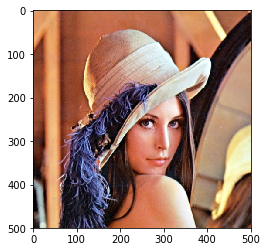

In [9]:
my_show(img)

# Gaussian kernel

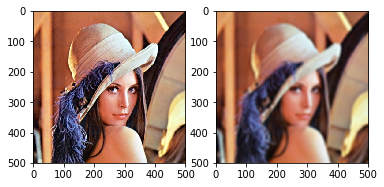

In [12]:
# Gaussian Kernel
g_img = cv2.GaussianBlur(img,(11,11),50)
plt.subplot(121)
my_show(img)
plt.subplot(122)
my_show(g_img)

# 卷积核大了, 滑动的范围就大了, 图像就更模糊
# 而方差\sigma影响不是很大
# 如果卷积核大 ,方差小,也不是很模糊

In [19]:
# 查看高斯核, 这里只有一个方向的
kernel_1d= cv2.getGaussianKernel(11,20)

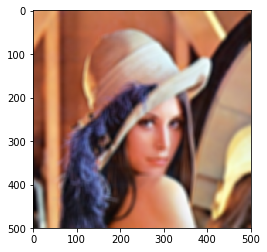

In [20]:
# 两个方向分开做卷积
g1_img = cv2.sepFilter2D(img, -1, kernel_1d, kernel_1d)
my_show(g1_img)

# Laplacian 

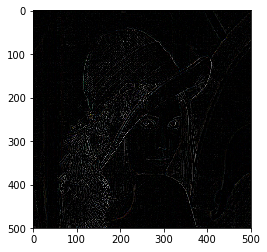

In [24]:
lap_kernel = np.array([[0,1,0], [1,-4,1],[0,1,0]])
lap_img = cv2.filter2D(img, -1, lap_kernel)
my_show(lap_img)

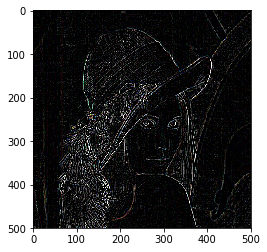

In [26]:
# 加强版
strong_kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
strong_lap_img = cv2.filter2D(img, -1, strong_kernel)
my_show(strong_lap_img)

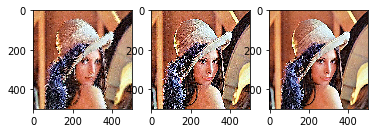

In [34]:
# 锐化, 把卷积后的图像加到原图上,就可以锐化图像
sharpen_kernel = np.array([[1,1,1],[1,-7,1],[1,1,1]])
sharpen_img = cv2.filter2D(img, -1, sharpen_kernel)
plt.subplot(131)
my_show(sharpen_img)

sharpen_minus_kernel =  np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
sharpen_img_2 = cv2.filter2D(img, -1, sharpen_minus_kernel)
plt.subplot(132)
my_show(sharpen_img_2)

sharpen_weak_kernel =  np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
sharpen_img_3 = cv2.filter2D(img, -1, sharpen_weak_kernel)
plt.subplot(133)
my_show(sharpen_img_3)

# Sobel

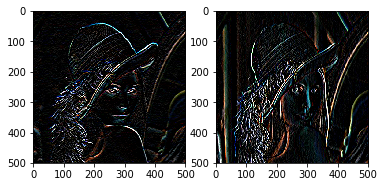

In [39]:
# y 方向
sobel_y_kernel =  np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
sobel_y_img = cv2.filter2D(img, -1, sobel_y_kernel)
plt.subplot(121)
my_show(sobel_y_img)

# x 方向
sobel_x_kernel =  np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_x_img = cv2.filter2D(img, -1, sobel_x_kernel)
plt.subplot(122)
my_show(sobel_x_img)

# Median blur

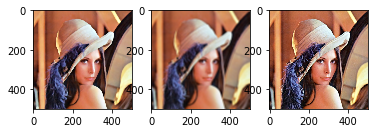

In [41]:
md_img = cv2.medianBlur(img,7)
plt.subplot(131)
my_show(md_img)

plt.subplot(132)
my_show(g_img)

plt.subplot(133)
my_show(img)

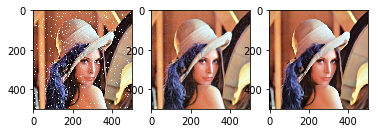

In [45]:
nosiy_img = cv2.imread("noisy_lenna.jpg",1)
plt.subplot(131)
my_show(nosiy_img)
g_noisy_img = cv2.GaussianBlur(nosiy_img,(7,7),2)
plt.subplot(132)
my_show(g_noisy_img)
md_noisy_img = cv2.medianBlur(nosiy_img,7)
plt.subplot(133)
my_show(md_noisy_img)

# 特征点 Feature Points


## 引言

卷积可以求导数

可以模糊降噪等等

可以滤波,滤波操作还是停留在图像处理操作

但是实际中我们更需要从图像中得到有用的特征

图像是像素,但这个特征太底层了

我们需要高级特征

比如一阶二阶导,可以把边缘信息告诉我们

比如角点,比如三角形的三个角

为什么需要特征点?

因为它能更好描述一个物体

## 什么是特征点

可以代表一个物体,可以从一个物体上取几个图像区域,他们组合起来能代表这个物体

比如考虑这样一个实际问题:

    多张图视角不一样,拍摄一个物体,如何把他们拼接成一张图

    matcing key point是核心工作

## 什么组成一个特征点

位置信息(坐标), 一些独特的特征属性x(x1,x2...xn]

## 应用:
- 
    - stitcing 拼接
    - classification 分类
    - reconstruction 重构
-  
    - look for pixels
    - objects representation目标表示
- 
    - feature points
- cv

这四个应用是个不断迭代的过程

## 什么是一个好的特征点

### 信息量十足 - 角点

比如边缘点/角点, 角点有个**Harris Corner Detector**算法
    
只有当某图像在某点上,不管图像怎么移动,它前后像素的差异都很大,这个点叫角点
$$
E=\sum_{(x,y)\in Window}^{ } [I(x+\Delta x,y+\Delta y )-I(x,y)]^2
$$
不管delta x, delta y怎么取,E都大,(x,y)∈Window即为所求

对E求导,再泰勒展开,得到
$$
E= [\Delta x, \Delta y]\sum_{(x,y)\in Window}^{ }\begin{bmatrix}I_{x}^{2}&I_{x}I_{y}\\I_{x}I_{y}&I_{y}^{2}\end{bmatrix}\begin{bmatrix}\Delta x\\\Delta y\end{bmatrix}
$$
任意delta x, delta y, E要大,只需中间那个矩阵(记作M)大. 

这是个实对称方阵,可以正交相似对角化:
$$
E=[\Delta x,\Delta y]P\begin{bmatrix}\lambda _{1} & 0\\ 0&\lambda _{2}\end{bmatrix}P^T\begin{bmatrix}\Delta x\\\Delta y\end{bmatrix}
$$
最终
$$
E= [\Delta x',\Delta y']\begin{bmatrix}\lambda _{1} & 0\\0&\lambda_{2}\end{bmatrix}[\Delta x',\Delta y']^T
$$

\lambda1 和\lambda2相近且都很小, 很多点聚集在一个点附近

\lambda1 和\lambda2都要大, 很多点以两边聚集在某个点附近,这就是角点

\lambda1 >>lambda2, 这是一条边
$$
\left\{\begin{matrix}
\lambda_{1} \cdot\lambda_{2}=Det(M)  \\ 
\lambda_{1} +\lambda_{2}=Trace(M) 
\end{matrix}\right.
$$
Harris Corner发明了这个R判据 :
$$
R=\lambda_{1}\cdot\lambda_{2}-k(\lambda_{1}+\lambda_{2})^2
$$
当R>threshold, 即判断这是个角点
harris虽然旋转不变,但是有缺点: 尺度.

因此加强,需要一个物理位置

# Harris Corner

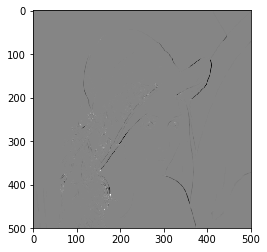

In [48]:
img_gray = (cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

img_harris = cv2.cornerHarris(img_gray,2,3,0.03)

plt.imshow(img_harris, cmap='gray')

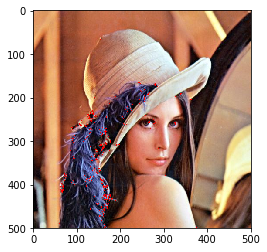

In [52]:
threshold = np.max(img_harris)*0.02

img[img_harris>threshold] = [0, 0 ,255] # B G R
my_show(img)

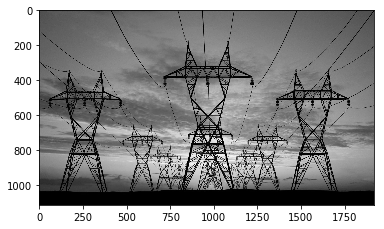

In [54]:
img_tower = cv2.imread("tower.jpg", 1)
img_tower_gray = cv2.cvtColor(img_tower, cv2.COLOR_BGR2GRAY)

plt.imshow(img_tower_gray, cmap='gray')

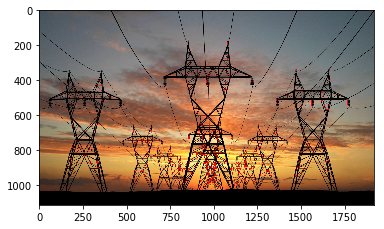

In [57]:
img_tower_harris = cv2.cornerHarris(img_tower_gray,2,3,0.03)

threshold_t = np.max(img_tower_harris)*0.02

img_tower[img_tower_harris>threshold_t] = [0,0,255]

my_show(img_tower)


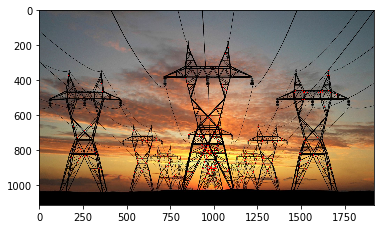

In [59]:
# 先把灰度图膨胀再做harris
img_tower_gray_dilate = cv2.dilate(img_tower_gray,None)

img_tower_dilate_harris = cv2.cornerHarris(img_tower_gray_dilate,2,3,0.03)

threshold_t = np.max(img_tower_dilate_harris)*0.02

img_tower_2 = cv2.imread("tower.jpg",1)
img_tower_2[img_tower_dilate_harris>threshold_t] = [0,0,255]

my_show(img_tower_2)

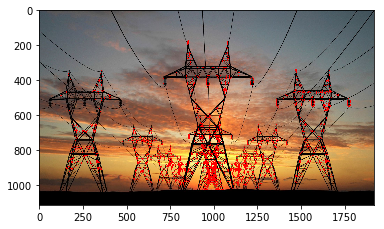

In [61]:
# 直接对harris进行膨胀
img_tower_dilate_harris_from_harris = cv2.dilate(img_tower_harris,None)
threshold_t = np.max(img_tower_dilate_harris_from_harris)*0.02
img_tower_3 = cv2.imread("tower.jpg",1)
img_tower_3[img_tower_dilate_harris_from_harris>threshold_t] = [0,0,255]
my_show(img_tower_3)

### SIFT算子
#### 引言

角点在图片旋转\调亮度等操作能够很好保持 robust鲁棒性

但是Harris算法有个缺点, 对Scale敏感

改进:
- physical location
- feature Descriptor
- SIFT

opencv-python需要3.4.2版本的

#### 1. Generate Scale-space: DOG 生成尺度空间

Difference of Gaussian 高斯差分

远处拍照然后近处拍照, 会模糊

仿照这一原理, 对一张图片,不断用Gaussian模糊来模拟尺度变化(偶数行列不要,然后做个高斯滤波)

这样得到一个金字塔,图片尺寸从下往上越来越小,叫高斯金字塔

高度是高斯方差, 每1个sigma作为一个组,作为每一个octave,每个octave中尺寸一样

然后每个octave中相邻两张做减法(差分), 则每组的图片总数减1

这样差分肯定得到的是边缘信息

#### 2. Scale-space Extrema Detection 极值点选择
在第一步的DOG找极值


中间图的图某个点,要比这张图这个点附近,上一张图\下张图这个点附近相比较看是不是极值,也就是1个点和26个点比较

所以在n张里找极值,需要n+3张

#### 3. Accurate Keypoint
上一步得到的值可能不够精确

用泰勒展开精确化
每一个

#### 4. Eliminating Edge Responses
DoG对于边缘敏感

需要\lambda1 >>lambda2

设$$ \lambda_{1} = a \lambda_{2}$$
当a>10:
$$ratio = \frac{(\lambda_{1}+\lambda_{2})^2}{\lambda_{1} \cdot \lambda_{2}} = 2 + a + \frac{1}{a} >12.1$$

#### 5. Oritentation Assignment 指定方向
用方向描述关键点很合适(特征),所以要找方向

对于某个关键点, 以4.5倍\sigma作为半径的圆圈,然后:
- 灰度梯度大小m(x,y)= 根号下(灰度x方向导数的平方+y方向导数的平方)
- 灰度梯度方向θ(x,y) = arctan(灰度y方向导数 / 灰度x方向导数)

对每一个点的灰度值进行计数投票: 
- 横轴: 把2pi 划分为10个bin
- 纵轴: 以点的梯度大小为权重,再根据位置高斯加权,再计数(两次加权)

最大值对应的θ, 主方向

第二高如果达到max的80%, 副方向

#### 6. Keypoint Descriptor

这一步是为了使特征点有旋转不变性

把图片旋转成 x轴为上一步主方向 的状态, 这样就不会受图片其他旋转的影响, (相当于有了自身的坐标系)

对点构建一个更大的区域 如4x4

对子区域做直方图统计, 子区域的每个小格有8个方向,总共128个向量

In [11]:
# SIFT
sift = cv2.xfeatures2d.SIFT_create()
img_new = cv2.imread("lenna.jpg",1)
kp = sift.detect(img_new)
print(len(kp))
kp, des= sift.compute(img_new, kp)
print(des.shape)
print(des[0])

1329
(1329, 128)
[  0.   0.   0.   0.   0.   0.   0.   0.  12.   4.   0.   0.   0.   4.
   5.   4.   5.   1.   0.   0.   0.  66.  76.  12.  14.   0.   0.   0.
   0.  34.  98. 136.  15.   3.   0.   0.   0.   0.   0.   1. 136.  17.
   0.   0.   0.   0.   2.  38.  53.   4.   0.   0.   0.   3.  66. 115.
  35.   0.   0.   0.   0.   2.  54. 136.  43.   1.   0.   0.   0.   0.
   1.  15. 136.  41.   0.   0.   0.   0.   0.  16. 136.  40.   0.   0.
   0.   0.   3.  68. 136.   1.   0.   0.   0.   0.   1. 136.  40.   7.
   0.   0.   0.   0.   0.   7. 136.  20.   0.   0.   0.   0.   0.  21.
 136.   6.   0.   0.   0.   0.   0. 135.  98.   1.   0.   8.   3.   0.
   0.  83.]


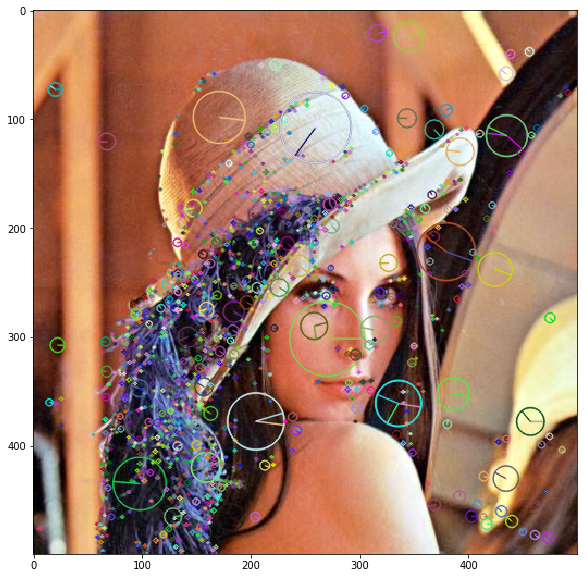

In [12]:
img_sift = cv2.drawKeypoints(img_new, kp, outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))

# 特征点的应用

## 图像拼接

随机采样一致算法 RANSAC很重要